# Data processing for Olive groves

Data processing for Fig. 4 and SI2 of [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0048969719361571).

### **Abstract**

World olive production is based on the cultivation of different varieties that respond differently to abiotic factors. Climate change may affect the area of land suitable for olive cultivation and change production levels, thus caus- ing serious damage to this economically-relevant and highly-productive olive grove agroecosystem. In Mediter- ranean regions such as Andalusia, one of the main areas of olive production, the effect of climate change seems threatening. Thus, our main aims are: (1) to examine the abiotic factors that characterise the current cultivated locations and predict the current and potential distribution of these locations; (2) to evaluate the effect of climate change (based on regional scenarios) on the future environmental suitability of each olive variety; and (3) to an- alyse the expected alteration in the annual olive production. We used the seven most-productive olive varieties in Andalusia and the wild olive species to develop Species Distribution Models (SDMs), coupled with soil prop- erties, geomorphology, water balance and (bio-)climatic predictors at a fine scale. We also derived future climate projections to assess the effect of climate change on the environmental suitability and productivity of each olive variety. 

**Olive varieties**

Among the long list of olive varieties which are currently cultivated in Andalusia, we selected those catalogued as “principal” and that are the most used in Andalusian olive groves in rain-fed regimes (Rubio de Casas et al., 2002), namely: Hojiblanca (Hj), Lechín de Sevilla (Lch), Manzanilla de Sevilla (Mnz), Nevadillo negro (Nvd), Picudo (Pcd), Picual (Pcl) and Verdial de Huévar (Vrd). We also used the wild olive tree (Acebuche, Oe), closely related to the domesticated olive tree. Two varieties stand out for their importance in terms of area in An- dalusia: Picual, which represents about 60% of the olive groves, and Hojiblanca, with around 20%.


| Target                              | Code   | Main features                                                | Area (km2)        |
|-------------------------------------|--------|--------------------------------------------------------------|-------------------|
|Acebuche                             |Oe      |Wild species of reference                                     | 2161              |
|Hojiblanca                           |Hj      |Very-frequent olive-tree variety cultivated in plant nurseries| 7868              |
|Lechín de Sevilla                    |Lch     |Frequent olive-tree variety in plant nurseries                | 3221              |
|Manzanilla de Sevilla                |Mnz     |Frequent olive-tree variety in plant nurseries                | 2654              |
|Nevadillo negro                      |Nvd     |Traditional olive-tree variety                                | 1114              |
|Picudo                               |Pcd     |Traditional olive-tree variety                                | 2459              |
|Picual                               |Pcl     |Very-frequent olive-tree variety cultivated in plant nurseries| 18,677            |         
|Verdial de Huévar                    |Vrd     |Traditional olive-tree variety                                | 865               |



**Regional climate projections for Andalusia**

To understand the future distribution and assess the environmental suitability of each olive variety, we used the Local Scenarios of Climate Change of Andalusia (ELCCA) (URL: [http://www.juntadeandalucia.es/ medioambiente/site/rediam](https://www.juntadeandalucia.es/medioambiente/portal/datos-ambientales?categoryVal=)). These regional climate change scenarios were specifically developed for the Andalusia region to represent the changes expected in the climate in the coming decades, according to studies carried out on a planetary scale. The scenarios were produced from the Third Generation Coupled Global Climate Model (MCGs; CNCM3), for a balance across all sources (A1b; IV IPCC Report), for three periods: `2011–2040` (“Proj-2040”), `2041–2070` (“Proj-2070”) and `2071–2100` (“Proj-2100”). 
The baseline (current) climatic data used to run the models comprised the average values for the interval `1961–2000`. From these simulations, (bio-)climatic variables (such as monthly precipitation and temperature) were derived. We then calcu- lated aggregation statistics (the mean as well as the 5%, 50% and 95% quantiles) for all the climatic variables, to assess projected changes in the study region.

# Setup
## Library import
We import all the required Python libraries

In [15]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import box
from tqdm import tqdm

# Data import
## Spatial projections of suitable area for all olive varieties
### Vector data
**Read data**

In [85]:
df_all = pd.read_csv('../../datasets/raw/crops/olivar/EnsSuitability_AllVarieties_Q95_woutNA.csv')
df_all.head()

,x,y,current.Q95,proj2040.Q95,proj2070.Q95,proj2100.Q95
0,-5.177276,38.721888,267.299988,299.450012,359.649994,371.750000
1,-5.067276,38.721888,538.900024,540.000000,533.599976,523.750000
2,-5.057276,38.721888,192.949997,339.149994,366.899994,389.200012
3,-5.047276,38.721888,204.800003,366.500000,384.250000,387.200012
4,-5.037276,38.721888,447.000000,512.400024,513.000000,499.750000


**Create grid**

In [12]:
gdf_all = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all.x, df_all.y))
gdf_all = gdf_all.set_crs("EPSG:4326")

In [16]:
# total area for the grid
xmin, ymin, xmax, ymax= gdf_all.total_bounds
# how many cells across and down
n_cells=gdf_all['x'].nunique()
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "EPSG:4326"
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(box(x0+cell_size*0.5, y0-cell_size*0.5, x1+cell_size*0.5, y1-cell_size*0.5)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

<AxesSubplot:>

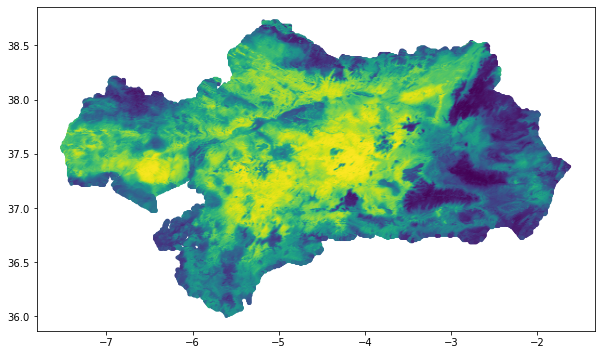

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
#cell.plot(ax=ax, facecolor="none", edgecolor='grey')
gdf_all.plot(ax=ax, column='current.Q95', markersize=8)
#ax.set_ylim([37.5,38]);
#ax.set_xlim([-5,-4.5]);

**Intersect points with grid**

In [ ]:
polygons = []
sindex = cell.sindex
# Iterate over the geometries
for n, geometry in enumerate(tqdm(gdf_all.geometry)):

    # Find approximate matches with r-tree
    possible_matches_index = list(sindex.intersection(geometry.bounds))
    possible_matches = cell.iloc[possible_matches_index]
    # Find precise matches with r-tree
    polygons.append(possible_matches[possible_matches.intersects(geometry)]['geometry'].iloc[0])

### Raster data
**Read data**

In [74]:
years_file = {'1961–2000': 'EnsSuitability_AllVarieties_Q95_Present.tif',
             '2011–2040': 'EnsSuitability_AllVarieties_Q95_Proj2040.tif',
             '2041–2070': 'EnsSuitability_AllVarieties_Q95_Proj2070.tif',
             '2071–2100': 'EnsSuitability_AllVarieties_Q95_Proj2100.tif'}

for i, year in enumerate(years_file.keys()):

    # Read tiff
    xda = xr.open_rasterio(f'../../datasets/raw/crops/olivar/{file_years[year]}').squeeze().drop("band")
    
    # replace all values equal to -3.4e+38 with np.nan
    xda = xda.where(xda != list(xda.attrs['nodatavals'])[0]) 
        
    # add time and depth coordinates
    xda = xda.assign_coords({"time": year}).expand_dims(['time'])
    
    # convert to Dataset and concatenate by depth
    if year == '1961–2000':
        xds = xr.Dataset({'EnsSuitability_AllVarieties_Q95': xda}, attrs=xda.attrs)
    else:
        xds_time = xr.Dataset({'EnsSuitability_AllVarieties_Q95': xda}, attrs=xda.attrs)

        xds = xr.concat([xds, xds_time], dim='time')

**Display data**

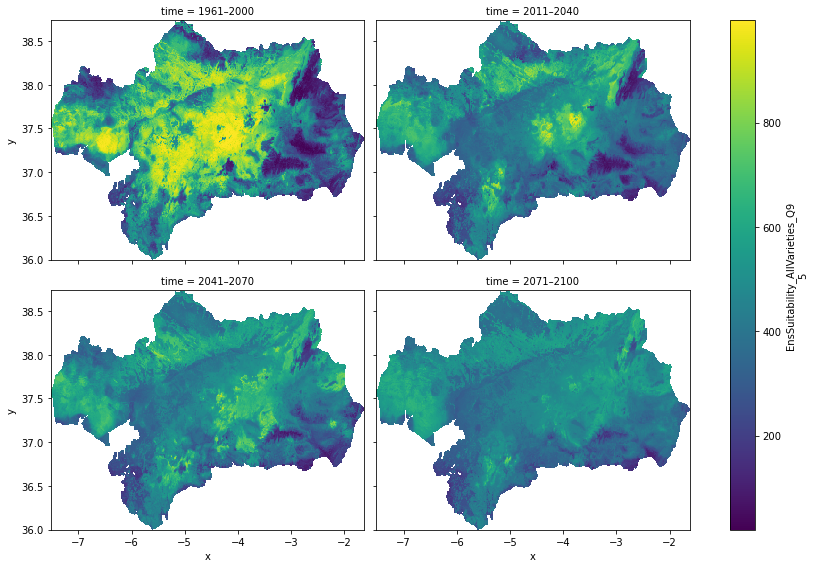

In [84]:
xds['EnsSuitability_AllVarieties_Q95'].plot(x="x", y="y", col="time", col_wrap=2, figsize=(12,8))

## Spatial projections of suitable area for each variety
### Raster data
**Read data**